In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import datetime
from calendar import monthrange
import pyupbit
import time

#user-defined
from Preprocess import Preprocess

In [5]:
'''Getting BTC data and saving as csv file'''
dataframe = pyupbit.get_ohlcv(ticker="KRW-XRP", interval="minute5", count=10000000)
print(dataframe)
dataframe['price'] = dataframe['value'] / dataframe['volume']
dataframe.to_csv("KRW-XRP.csv", index=True)

                      open   high    low  close         volume         value
2017-09-25 22:05:00  200.0  200.0  200.0  200.0       0.000200  4.000000e-02
2017-09-25 22:10:00  201.0  201.0  200.0  200.0       0.000200  4.010000e-02
2017-09-25 22:15:00  201.0  201.0  200.0  200.0       0.000200  4.010000e-02
2017-09-25 22:20:00  201.0  201.0  201.0  201.0       0.000200  4.020000e-02
2017-09-25 22:25:00  200.0  200.0  200.0  200.0       0.000100  2.000000e-02
...                    ...    ...    ...    ...            ...           ...
2024-01-09 14:25:00  767.0  768.0  767.0  768.0  244897.133511  1.878985e+08
2024-01-09 14:30:00  768.0  769.0  767.0  769.0  284290.410548  2.184242e+08
2024-01-09 14:35:00  768.0  769.0  766.0  766.0  352220.198889  2.702713e+08
2024-01-09 14:40:00  767.0  768.0  766.0  767.0  413927.677724  3.174452e+08
2024-01-09 14:45:00  767.0  768.0  766.0  767.0  266521.087995  2.044411e+08

[655709 rows x 6 columns]


In [3]:
dataset = dataframe[["close"]]

split = int(len(dataset) * 0.85)
price = dataset.to_numpy()
print(max(price), min(price))

tr = price[:split]
te = price[split:]

price = np.log(price/10000)

scaler = MinMaxScaler()

price = np.reshape(price, (len(price), 1))
price = scaler.fit_transform(price)
price = price.flatten()

trainset = price[:split]
testset = price[split:]

[4380.] [179.]


In [4]:
x_step = 10
y_step = 3

train_data = Preprocess().train(x_step, y_step, trainset)

train_x = train_data[0]
train_y = train_data[1]

for i in range(5):
    train_x = np.append(train_x, train_x, axis=0)
    train_y = np.append(train_y, train_y, axis=0)

train_x = np.reshape(train_x, (len(train_x), len(train_x[1]), 1))

In [5]:
model = Sequential()

model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=8))
model.add(Dense(3))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=5, batch_size=10, verbose=1)
model.summary()

2024-01-08 19:01:59.390464: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 19:01:59.710588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 975 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Epoch 1/5


2024-01-08 19:02:05.551192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500
2024-01-08 19:02:05.704270: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6199/6199 [==============================] - 46s 6ms/step - loss: 0.0022 - accuracy: 0.3367
Epoch 2/5
6199/6199 [==============================] - 40s 6ms/step - loss: 0.0011 - accuracy: 0.3494
Epoch 3/5
6199/6199 [==============================] - 39s 6ms/step - loss: 9.5775e-04 - accuracy: 0.3534
Epoch 4/5
6199/6199 [==============================] - 40s 6ms/step - loss: 8.9282e-04 - accuracy: 0.3535
Epoch 5/5
6199/6199 [==============================] - 39s 6ms/step - loss: 8.4317e-04 - accuracy: 0.3573
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           197120    
      

In [8]:
model.save('XRP_model_01_08/model.h5')

[0.07552864 0.07656999 0.07595682]


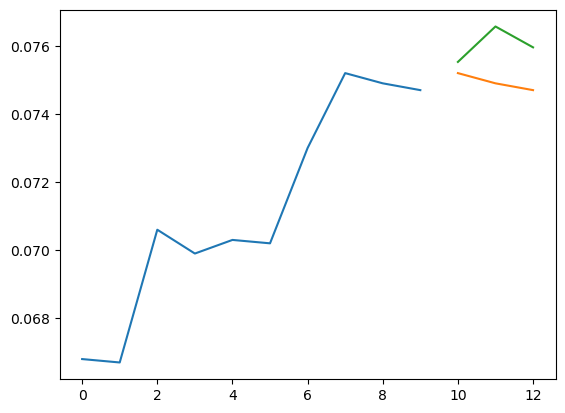

In [9]:
test = np.array([668, 667, 706, 699, 703, 702, 730, 752, 749, 747])/10000
test = np.log(test)

test = np.reshape(test, (10, 1))
test = scaler.transform(test)
test = np.reshape(test, (1, 10))

predict = model.predict(test)

predict = scaler.inverse_transform(predict)
predict = predict.flatten()
predict = np.exp(predict)

p_list = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,np.nan])
p_list = np.append(p_list, predict)
plt.plot(np.array([668, 667, 706, 699, 703, 702, 730, 752, 749, 747])/10000)
plt.plot(np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,np.nan, 752, 749, 747])/10000)
plt.plot(p_list)

print(predict)

2214
2223


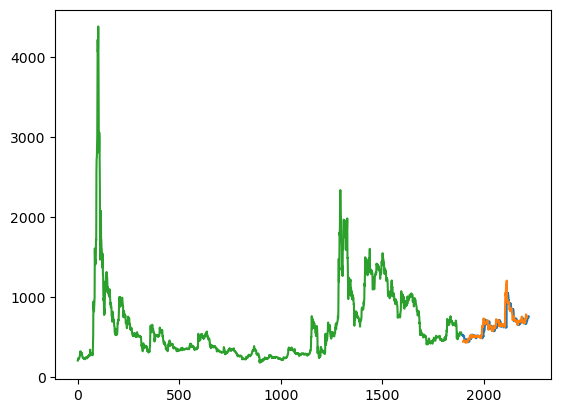

In [8]:
test_data = Preprocess().test(x_step, y_step, testset)

valid = np.array([])
for i in range(len(trainset)):
    valid = np.append(valid, np.nan)

valid = np.append(valid, te)

predict_list = np.array([])
for i in range(len(trainset)+x_step):
    predict_list = np.append(predict_list, np.nan)


for i in range(len(test_data)):
    test = np.reshape(test_data[i], (1, x_step))
    predict = model.predict(test)

    predict = scaler.inverse_transform(predict)
    predict = predict.flatten()
    predict = np.exp(predict)

    predict_list = np.append(predict_list, predict*10000)

print(len(predict_list))
print(len(valid))

plt.plot(valid)
plt.plot(predict_list)
plt.plot(tr)
plt.show()